In [3]:
from xmitgcm import open_mdsdataset
import xarray as xr
import numpy as np
import xgcm
import datetime
import os
from matplotlib import pyplot as plt 
from scipy import interpolate
import cartopy
import warnings; warnings.simplefilter('ignore')
from numba import jit

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, AdvectionRK4_3D, ErrorCode
import math
from datetime import timedelta
from operator import attrgetter


%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)

plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False



plot_dir = '/glade/u/home/myoungs/Figures/'+datetime.date.today().isoformat()+'/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

from dask.distributed import Client
client = Client()
client

ModuleNotFoundError: No module named 'xmitgcm'

In [2]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

def getCoeff(windstress,t,s):
    
    # define coeffs for Schmidt no
    sca1 = 2073.1
    sca2 = -125.62
    sca3 =    3.6276
    sca4 =   -0.043219
    
    SchmidtNoDIC = sca1 + sca2*t + sca3*t*t + sca4*t*t*t
    
    
    atmrho=1.2;
    recip_sqrtRhoA = 1/np.sqrt(atmrho);

    ustar = np.sqrt(windstress)*recip_sqrtRhoA;

    ustofu11 =  0.381800;
    u11 =  11 ;
    clindrag_1  =  0.000065;
    clindrag_2  =  0.000490;
    cquadrag_1  = clindrag_1/u11/2;
    cquadrag_2  = clindrag_1*u11/2 + clindrag_2;
 
 #if ( ustar .LT. ustofu11 )
    tmp1 = -cquadrag_2/cquadrag_1*0.5;
    tmp2 = np.sqrt(tmp1*tmp1 + ustar*ustar/cquadrag_1);
    wind = np.sqrt(tmp1 + tmp2);
    
    
    #print(np.array(wind[:,0]))
    #calculate piston velocity
    pisvel=0.337*wind**2/3.6e5
    
    # not sure if this goes here or if we need it              pCO2sat(i,j) = AtmosP(i,j,bi,bj)*AtmospCO2(i,j,bi,bj)

# then account for Schmidt number
    Kwexch = pisvel/(np.sqrt(SchmidtNoDIC/660))
    
    tk = 273.15 + t
    tk100 = tk/100
    tk1002=tk100*tk100

    P1atm = 1.01325 # bars
    Rgas = 83.1451 # bar*cm3/(mol*K)
    RT = Rgas*tk
    delta = (57.7  - 0.118*tk)
    B1 = -1636.75 + 12.0408*tk - 0.0327957*tk*tk
    B = B1 + 3.16528 *tk*tk*tk*(0.00001)
    
    fugf = np.exp( (B+2*delta) * (P1atm/RT))

          
    ff = np.exp(-162.8301 + 218.2968/tk100  +   90.9241*np.log(tk100) - 1.47696 *tk1002 +
               s * (.025695  - .025225*tk100 +  0.0049867*tk1002))

    ak0 = np.exp(93.4517/tk100 - 60.2409 +  23.3585 * np.log(tk100) +
            s * (0.023517 - 0.023656*tk100 +  0.0047036*tk1002))
            

    return ff, fugf, ak0, Kwexch

#def Coeff_vec(a, b, c):
    # apply ufunc wrapper
 #   return xr.apply_ufunc()


def FluxCO2(wind, t, s, pCO2):
    ff, fugf, ak0, Kwexch = getCoeff(wind,t,s)
    
    Flx = Kwexch*(ff*278e-6 -  pCO2*fugf*ak0)*1024.5 ##  should be multiply, have checked multiple times

    
    return Flx


## Read in data

In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False

#run = 'layers0.15'


plot_dir = '/glade/u/home/myoungs/Figures/'+datetime.date.today().isoformat()+'/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

#for x in run:
    ## read in data #######
      
#data_dir_m = '/glade/scratch/myoungs/'+run_m
data_dir = '/glade/campaign/univ/umit0025/newcarbon/dop_15'

print(data_dir)
    

#iters2 = range(72112464,72164880,144)
#dsmean = open_mdsdataset(data_dir,prefix=['DIAG','DIAGLayer','DIAGSurf'],delta_t=600,iters = iters1)
ds = open_mdsdataset(data_dir,prefix=['DIAG','DIAGTracer','DIAGSurf'])#,iters=iters2)


#ds =  open_mdsdataset(data_dir,prefix=['DIAGLayer','DIAG'],delta_t=600)
#                        # ignore_unknown_vars==True)#,iters='377225') # ,'DIAGTracer'
grid = xgcm.Grid(ds, periodic=['X'])
#gridmean = xgcm.Grid(dsmean, periodic=['X'])
ds

ds4 = xr.Dataset({"UVEL_C":  
        (("time", "YC","XC"),grid.interp(ds.UVEL[:,19],'X').data),
        "VVEL_C": (("time", "YC","XC"), grid.interp(ds.VVEL[:,19].data,'Y',boundary='extend')),
        "THETA": (("time", "YC","XC"), ds.THETA[:,0]),
        "DIC": (("time", "YC","XC"), ds.TRAC01[:,0]),
        "ALK": (("time", "YC","XC"), ds.TRAC02[:,0]),
        "DICFLX": (("time", "YC","XC"), ds.DICCFLX),
        "pH":(("time", "YC","XC"), ds.DICPHAV),
        "pCO2":(("time", "YC","XC"), ds.DICPCO2),
        "TAU":(("time", "YC","XC"), ds.oceTAUX)        },
    coords={"time":ds.time, "YC": ds.YC,"XC":ds.XC})

#ds4.to_netcdf('/glade/p/univ/umit0025/newcarbon/dop_15/testdataArgo.nc')

/glade/p/univ/umit0025/newcarbon/dop_15


TypeError: All data arguments must be either a DataArray or Dictionary Got <class 'dask.array.core.Array'>.

## Set up floats for carbon

distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


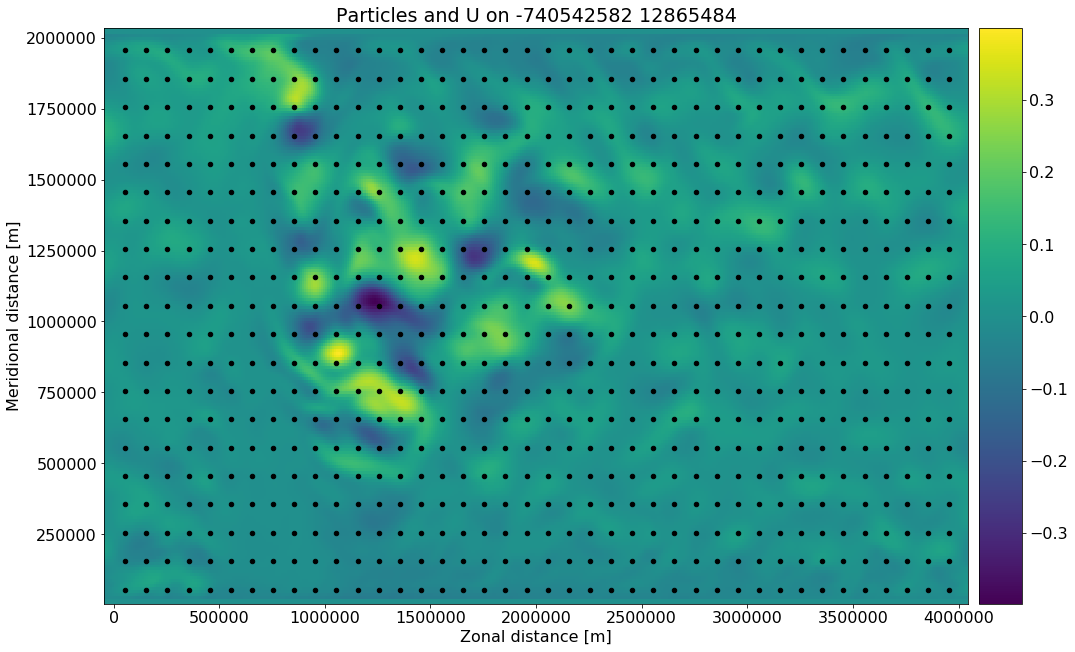

In [8]:
variables = {'U': 'UVEL_C', 'V': 'VVEL_C','T':'THETA','DIC':'DIC',
             'ALK':'ALK','DICFLX':'DICFLX','pH':'pH','pCO2':'pCO2','TAU':'TAU'}
dimensions = {'time': 'time','lat': 'YC', 'lon': 'XC' }

repeatdt = timedelta(days=364) 
fieldset = FieldSet.from_netcdf('/glade/campaign/univ/umit0025/newcarbon/dop_15/testdataArgo.nc',variables, dimensions,mesh='flat',
                                time_periodic=repeatdt,field_chunksize='auto')#{'time': 20, 'lat': 204, 'lon': 400})
fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

        
class SampleParticle(JITParticle):         # Define a new particle class
    t = Variable('t', initial=0.) 
    dic = Variable('dic', initial=0.) 
    alk = Variable('alk', initial=0.)
    dicflux = Variable('dicflux',initial=0.)# Variable 't' initialised by sampling the temperature
    ph = Variable('ph',initial=0.)
    pco2 = Variable('pco2',initial=0.)
    tau = Variable('tau',initial=0.)
    xdisp = Variable('xdisp', initial=0., to_write=False)
    ydisp = Variable('ydisp', initial=0., to_write=False)
    vtot = Variable('vtot',initial=0., to_write=False)
    utot = Variable('utot',initial=0., to_write=False)
    
    
    
def periodicBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle.lon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle.lon -= fieldset.halo_east - fieldset.halo_west
        
        
def SampleP(particle, fieldset, time):  # Custom function that samples fieldset.P at particle location
    particle.t = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    particle.dic = fieldset.DIC[time, particle.depth,particle.lat, particle.lon]
    particle.alk = fieldset.ALK[time, particle.depth, particle.lat, particle.lon]
    particle.dicflux = fieldset.DICFLX[time, particle.depth, particle.lat, particle.lon]
    particle.ph = fieldset.pH[time, particle.depth, particle.lat, particle.lon]
    particle.pco2 = fieldset.pCO2[time, particle.depth, particle.lat, particle.lon]
    particle.vtot = fieldset.V[time, particle.depth, particle.lat, particle.lon]
    particle.utot = fieldset.U[time, particle.depth, particle.lat, particle.lon]
    particle.tau = fieldset.TAU[time, particle.depth, particle.lat, particle.lon]

def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
def NBMLDelete(particle, fieldset, time):
    if particle.xdisp > 2.5e5 or particle.xdisp < -2.5e5:
        particle.delete()
    if particle.ydisp > 2.5e5 or particle.ydisp < -2.5e5:
        particle.delete()

def MeanUpwelling(particle, fieldset, time):  
    particle.xdisp += particle.utot*particle.dt
    particle.ydisp += particle.vtot*particle.dt
    
    
xgrid, ygrid = np.meshgrid(np.array(ds.XC[range(5,400,10)]), np.array(ds.YC[range(5,200,10)]))
xs1 = np.reshape(xgrid,800)
ys1 = np.reshape(ygrid,800)

#repeatdt = timedelta(days=30) 
pset = ParticleSet.from_list(fieldset=fieldset, pclass=SampleParticle, lon=xs1, lat=ys1, time=0)
pset.show(field=fieldset.U)

## Run floats

INFO: Compiled SampleParticleAdvectionRK4periodicBCSamplePMeanUpwelling ==> /glade/scratch/myoungs/parcels-20804/89120a29f98fcc345fa0cec86ac929d3_0.so
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
INFO: Temporary output files are stored in /glade/p/univ/umit0025/newcarbon/dop_15/out-OEFBEIKE.
INFO: You can use "parcels_convert_npydir_to_netcdf /glade/p/univ/umit0025/newcarbon/dop_15/out-OEFBEIKE" to convert these to a NetCDF file during the run.
N/A% (0 of 94608000.0) |                 | Elapsed Time: 0:00:00 ETA:  --:--:--distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
  0% (604800.0 of 94608000.0) |          | Elapsed Time: 0:00:06 ETA:   0:43:13distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
  0% (864000.0 of 94608000.0) |          | Elapsed Time: 0:00:14 ETA:   0:44:45distributed.utils_perf - WARNING - full garbage

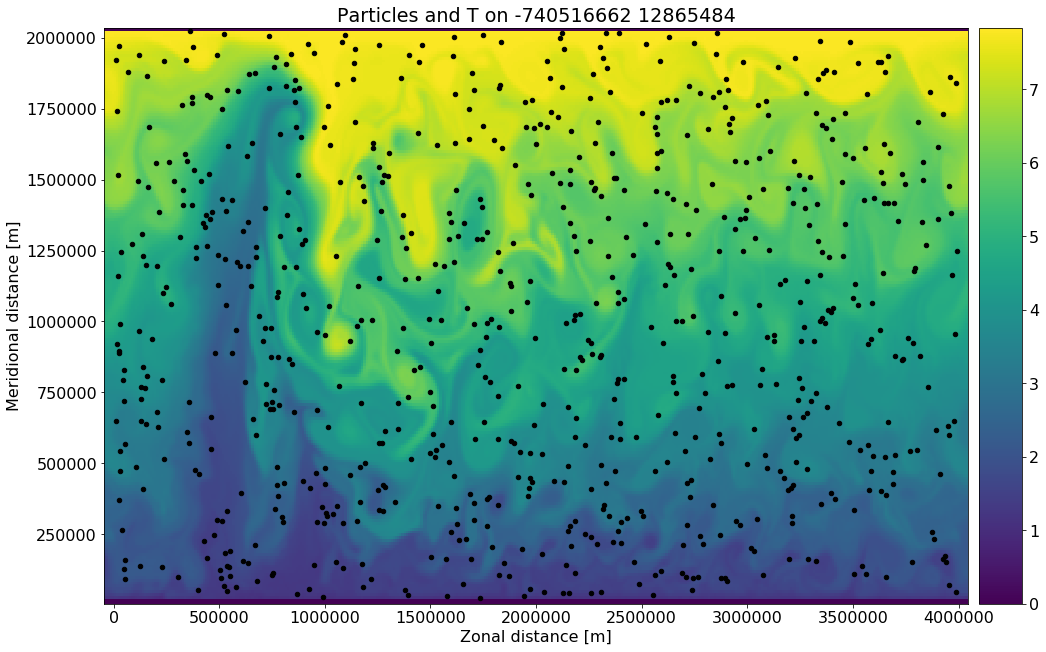

Temp values after execution: [5.489863, 3.8519783, 4.006856, 5.958315, 6.8607526, 4.640046, 6.574675, 5.36219, 3.8004377, 4.400935, 2.3761954, 4.1128907, 7.674205, 4.2242637, 1.604581, 1.3603288, 1.6223761, 1.5765563, 2.9970336, 1.5928177, 3.5983067, 1.4891902, 3.8708093, 1.5674994, 1.3757952, 2.8247216, 1.3448017, 1.8914434, 1.7522223, 1.8115044, 1.9859209, 1.4859002, 1.400424, 1.5478829, 1.2849344, 1.7200159, 1.4766066, 2.9783401, 2.4988012, 1.8042665, 3.0598807, 6.8520746, 3.899177, 5.5804095, 5.4679847, 2.9156919, 7.0920773, 3.840581, 4.5394287, 1.4281449, 2.7866366, 2.8744333, 5.5086145, 3.628778, 1.5406872, 3.6333303, 6.124625, 3.8694654, 1.6598481, 1.341702, 3.5932014, 2.626623, 1.8144186, 5.619399, 1.6939965, 1.6662155, 1.5350214, 2.17069, 1.5765567, 1.3330489, 1.7651721, 1.2799323, 2.2183325, 1.773725, 1.6353693, 2.2995822, 2.1520257, 2.6231968, 1.3396132, 1.3127688, 4.8305097, 3.493824, 7.506232, 7.5952, 3.3899379, 3.7016976, 3.5216224, 3.5851808, 1.5931956, 2.4628124, 3.4968

In [9]:
output_file = pset.ParticleFile(name="/glade/p/univ/umit0025/newcarbon/dop_15/Argo800pCO2_3year.nc", outputdt=timedelta(hours=240)) # the file name and the time step of the outputs

# pset.execute(AdvectionRK4 + pset.Kernel(periodicBC), # add kernel for periodicity

pset.execute(AdvectionRK4  +  pset.Kernel(periodicBC)+ pset.Kernel(SampleP)  + pset.Kernel(MeanUpwelling),# +  +,# the kernel (which defines how particles move)
             runtime=timedelta(days=1095),    # 1800 the total length of the run
             dt=timedelta(minutes=60),      # the timestep of the kernel
             output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

#pset.repeatdt = None
#pset.execute(AdvectionRK4_3D  + pset.Kernel(SampleP) + pset.Kernel(NBMLDelete) + pset.Kernel(MeanUpwelling),# the kernel (which defines how particles move)
#             runtime=timedelta(days=1790),    # 1800 the total length of the run
#             dt=timedelta(minutes=60),      # the timestep of the kernel
#             output_file=output_file,
#             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})


#print(pset)
#pset.show(field=fieldset.U)

pset.show(field=fieldset.T)#, show_time=0)
print('Temp values after execution:', [t.t for t in pset])

output_file.export()
output_file.close()
#plotTrajectoriesFile('/glade/p/univ/umit0025/newcarbon/dop_15/Argo800pCO2.nc',mode='2d');

## Map floats PCO2

In [2]:
dst = xr.open_dataset('/glade/p/univ/umit0025/newcarbon/dop_15/Argo800pCO2.nc',decode_times=False)
dst

ds4 = xr.open_dataset('/glade/p/univ/umit0025/newcarbon/dop_15/testdataArgo.nc',decode_times=False)

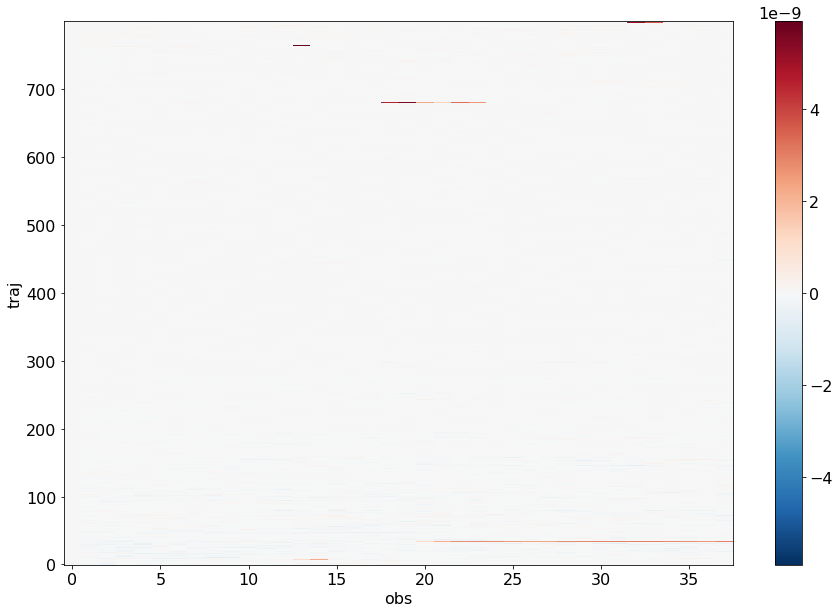

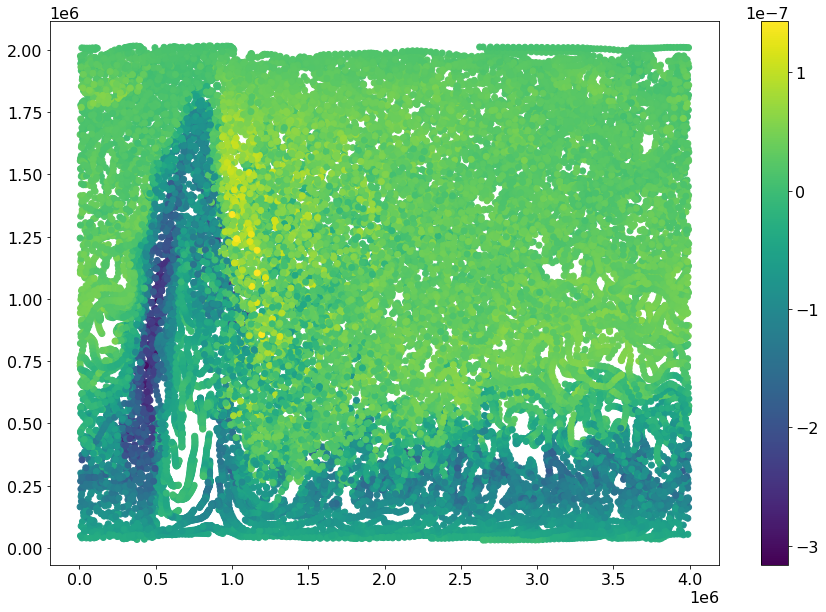

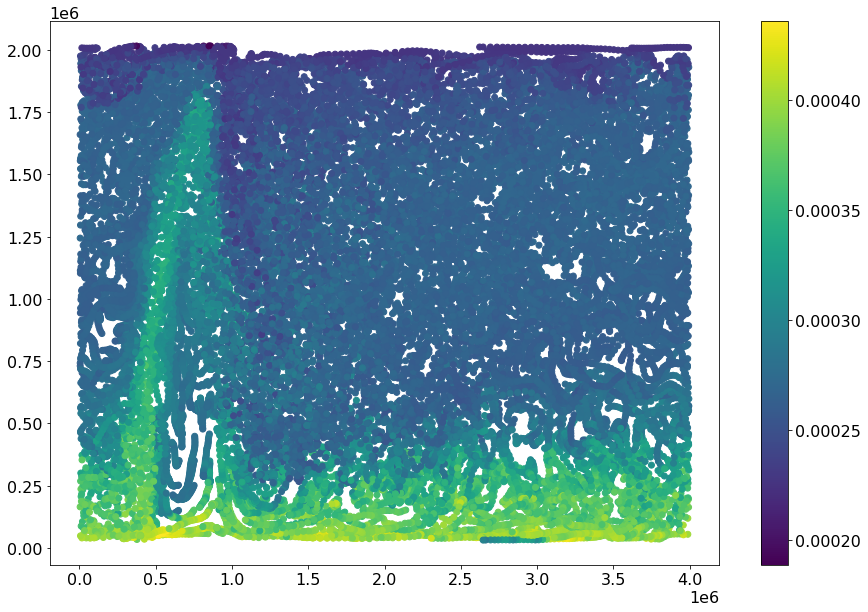

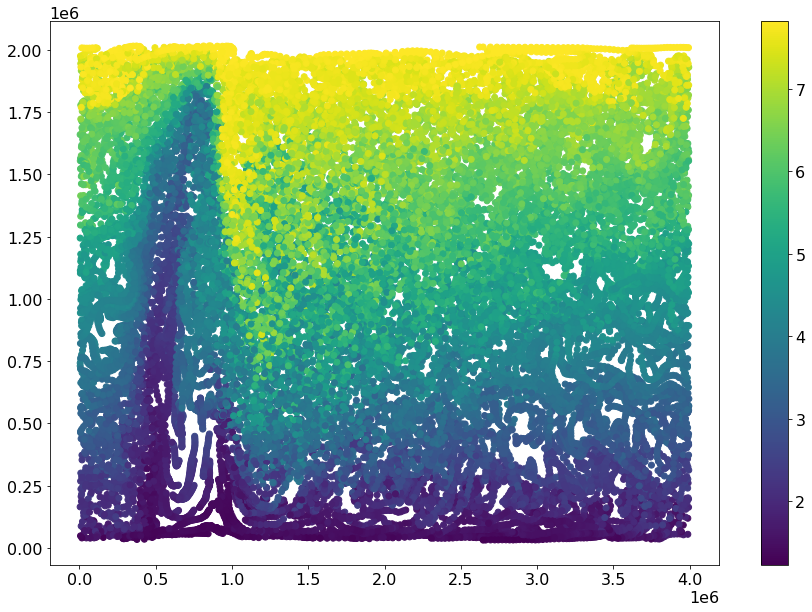

In [4]:
flux = FluxCO2(dst.tau,dst.t,35,dst.pco2)
plt.figure()
(flux-dst.dicflux).plot()

plt.figure()
plt.scatter(dst.lon[:,1:],dst.lat[:,1:],c=flux[:,1:])
plt.colorbar()


plt.figure()
plt.scatter(dst.lon[:,1:],dst.lat[:,1:],c=dst.pco2[:,1:])
plt.colorbar()

plt.figure()
plt.scatter(dst.lon[:,1:],dst.lat[:,1:],c=dst.t[:,1:])
plt.colorbar()
#errors in flux calc  due to particle mapping is two orders of magnitude smaller than signal (if not less)

In [26]:
xi = np.linspace(0,4000000,400)
yi = np.linspace(0,2040000,204)
xg, yg = np.meshgrid(xi,yi)
percentdif = np.empty(0)
percentdif2 = np.empty(0)
for i in np.arange(1):
    print(i)
    #indices = np.random.choice(dst.lon.shape[0],33,replace = False)
    indices = [222, 211, 436, 154, 448, 137, 304, 315,  33, 540,  56, 196, 345, 305,  42, 683,  97,  
               25, 264, 128, 573, 770, 630, 481, 227, 79, 759, 708, 445, 111, 500, 441, 220]
    OK = OrdinaryKriging(
        np.array(dst.lon[indices,1:]).flatten(),
        np.array(dst.lat[indices,1:]).flatten(),
        np.array(dst.pco2[indices,1:]).flatten(),
        variogram_model="gaussian",
        verbose=False,
        enable_plotting=False)
    
    z, ss = OK.execute("grid", xi, yi)
    
    OK2 = OrdinaryKriging(
        np.array(dst.lon[indices,1:]).flatten(),
        np.array(dst.lat[indices,1:]).flatten(),
        np.array(dst.t[indices,1:]).flatten(),
        variogram_model="linear",
        verbose=False,
        enable_plotting=False)
    z2, ss2 = OK2.execute("grid", xi, yi)

    # calculate air-sea fluxes
    zflux = FluxCO2(grid.interp(ds.oceTAUX[-1],'X'),z2,35,z)
    
    difcalc = (np.array(((3600*24*360*(ds4.DICFLX[:,3:-2].mean(dim='time')-zflux[3:-2]))).sum(dim='XC').sum(dim='YC')))
    baseline = (np.array(((3600*24*360*(ds4.DICFLX[:,3:-2].mean(dim='time')-0*zflux[3:-2]))).sum(dim='XC').sum(dim='YC')))
    percentdif = np.append(percentdif,difcalc/baseline)
    
#    difcalc2 = (np.array(((3600*24*360*(ds4.DICFLX[:,3:-2].mean(dim='time')-z2[3:-2]))).sum(dim='XC').sum(dim='YC')))
#    baseline2 = (np.array(((3600*24*360*(ds4.DICFLX[:,3:-2].mean(dim='time')-0*z2[3:-2]))).sum(dim='XC').sum(dim='YC')))
#    percentdif2 = np.append(percentdif2,difcalc2/baseline2)

print(percentdif)
#print(percentdif2)

0
[-0.18953627]


## Map float CO2 fluxes

1.100174330773231e-06

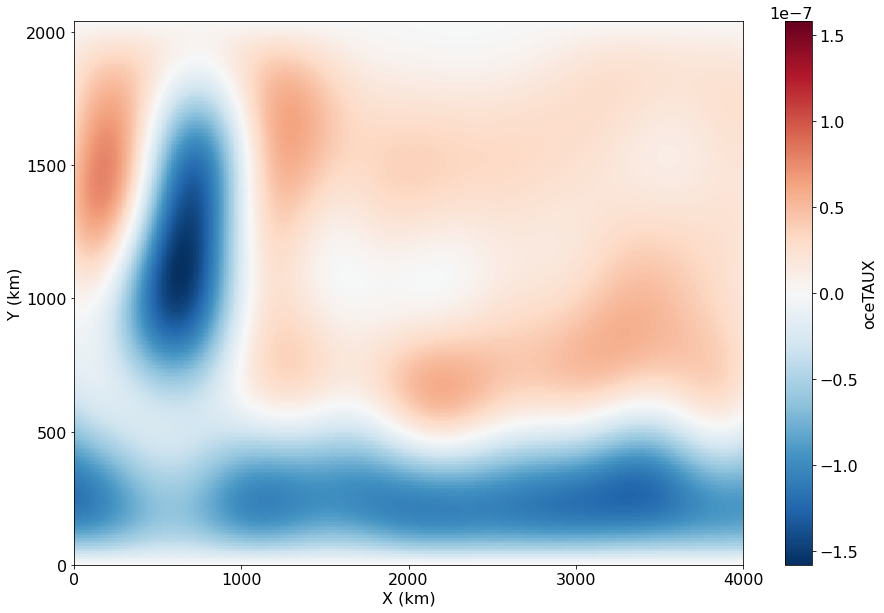

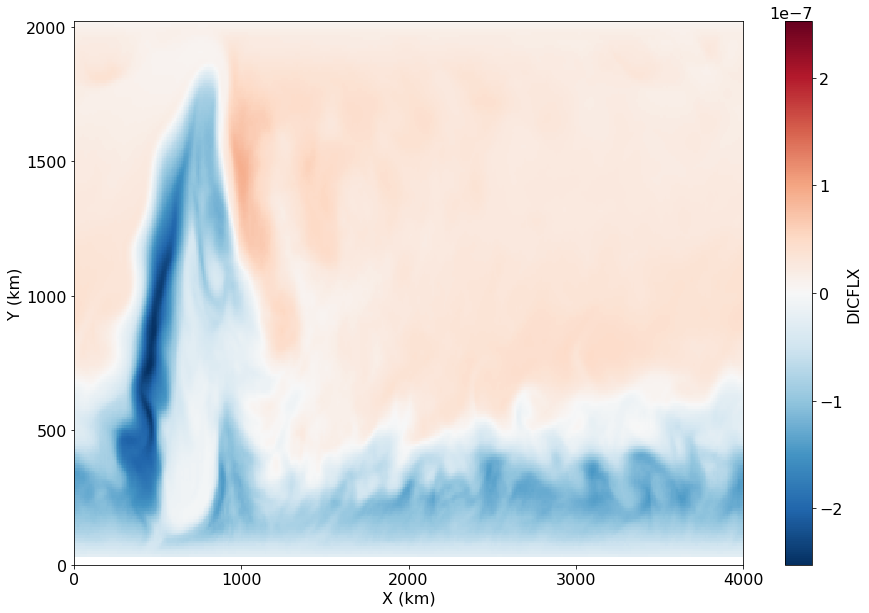

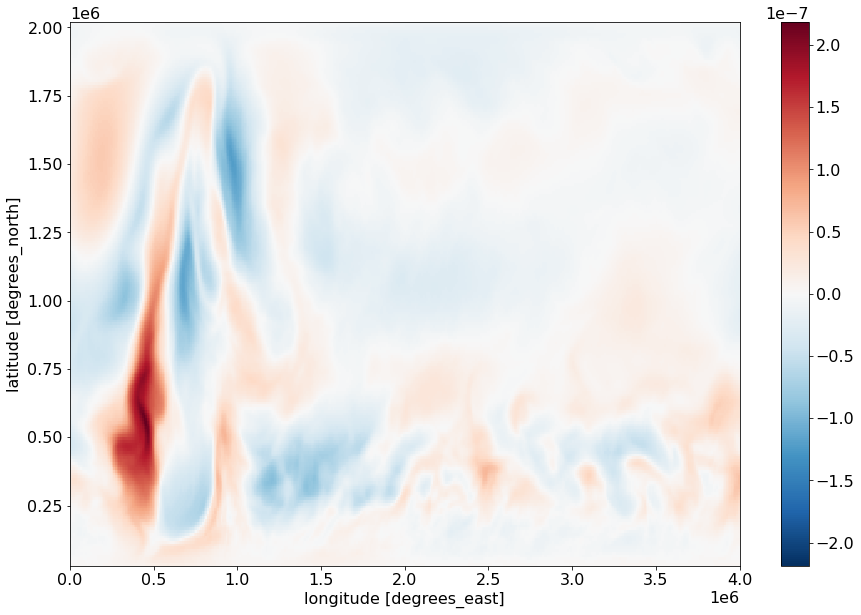

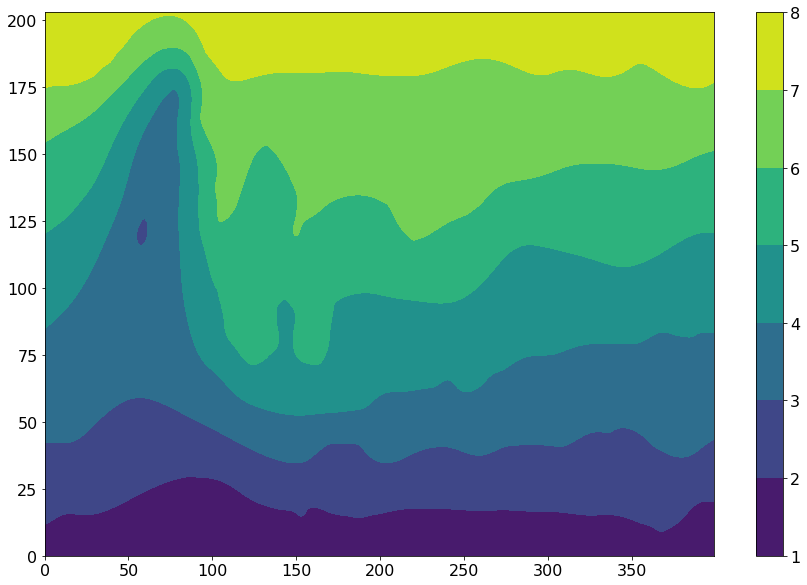

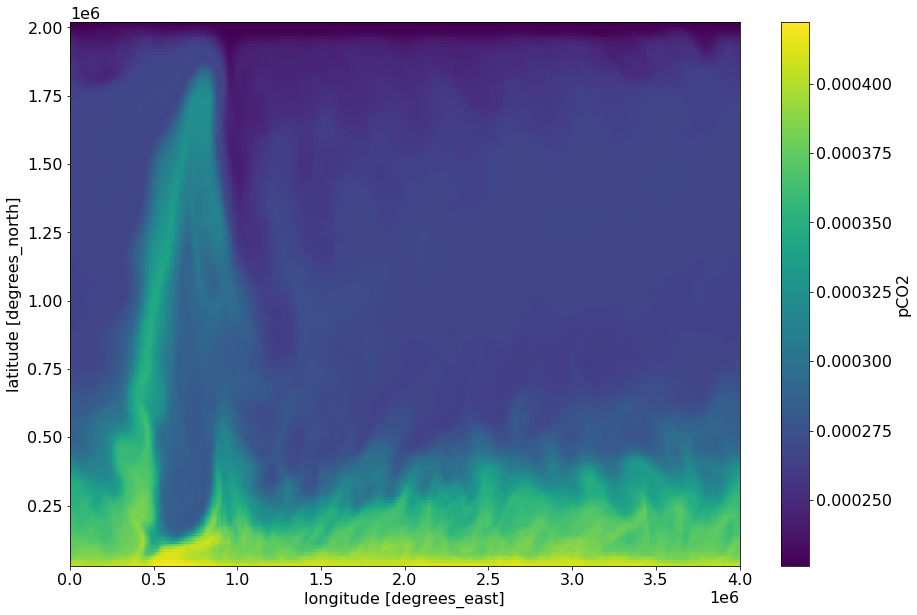

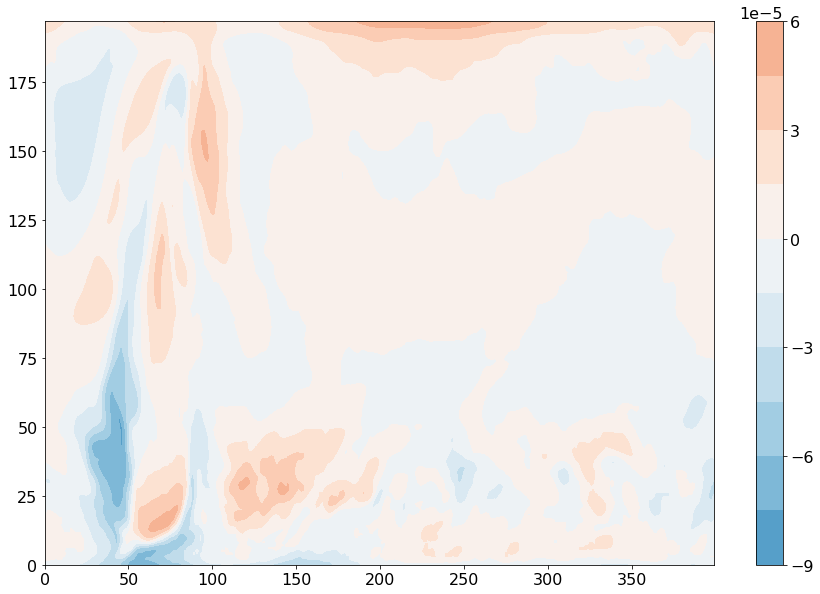

In [27]:
plt.figure()
zflux.plot()
plt.title('')
plt.yticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.ylabel('Y (km)')
plt.xticks([0,1000000,2000000,3000000,4000000],[0,1000,2000,3000,4000])
plt.xlabel('X (km)')

plt.savefig(plot_dir+'MappedCO2Flux'+'dop15'+'.eps',bbox_inches='tight')


plt.figure()
ds4.DICFLX[:,3:-2].mean(dim='time').plot()
plt.title('')
plt.yticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.ylabel('Y (km)')
plt.xticks([0,1000000,2000000,3000000,4000000],[0,1000,2000,3000,4000])
plt.xlabel('X (km)')

plt.savefig(plot_dir+'CO2Flux'+'dop15'+'.eps',bbox_inches='tight')


plt.figure()
(zflux - ds4.DICFLX[:,3:-2].mean(dim='time')).plot()


plt.figure()
plt.contourf(z2)
plt.colorbar()


plt.figure()
ds4.pCO2[:,3:-2].mean(dim='time').plot()
#plt.colorbar()

plt.figure()
plt.contourf(z[3:-3]-ds4.pCO2[:,3:-3].mean(dim='time'),vmin = -0.00015, vmax = 0.00015, levels = 11,cmap=plt.cm.RdBu_r)
plt.colorbar()


out = (z[3:-3]-ds4.pCO2[:,3:-3].mean(dim='time'))
np.mean(out)

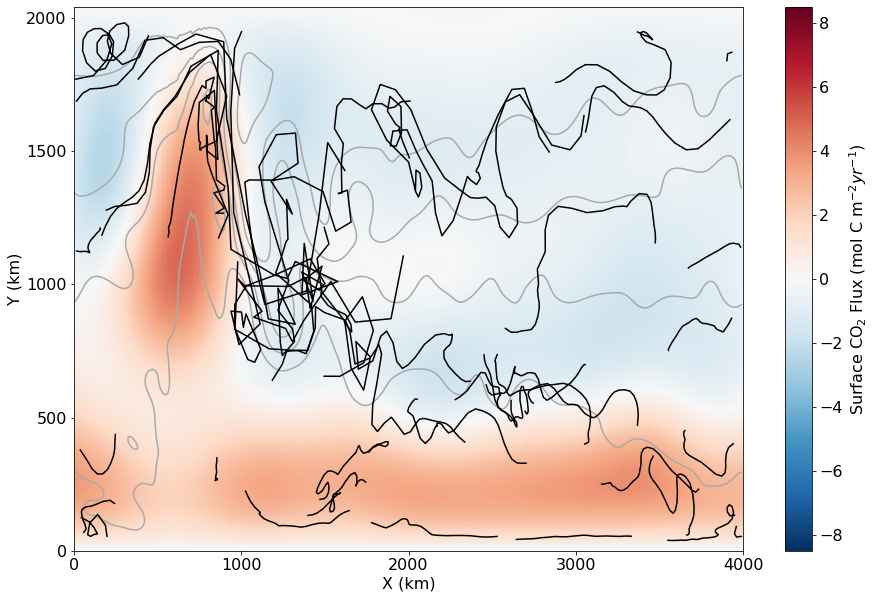

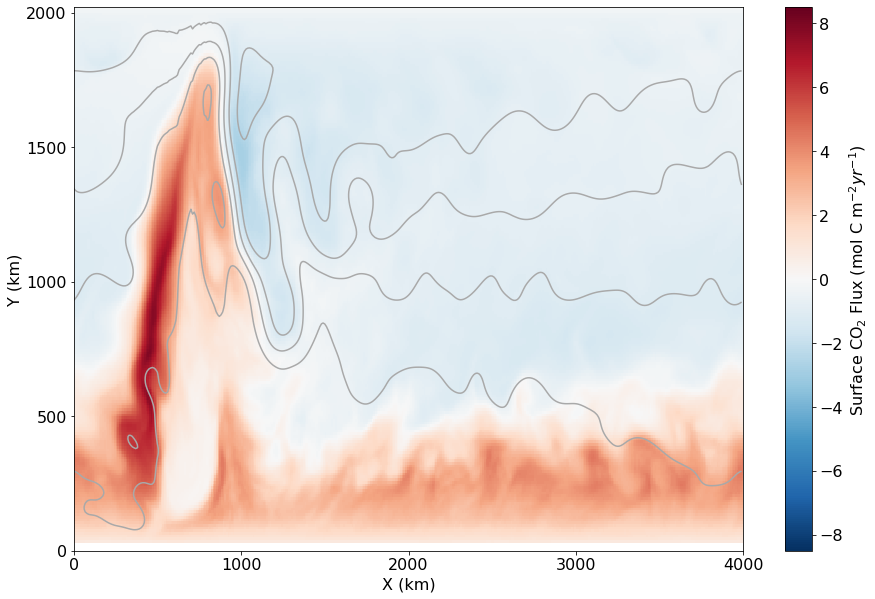

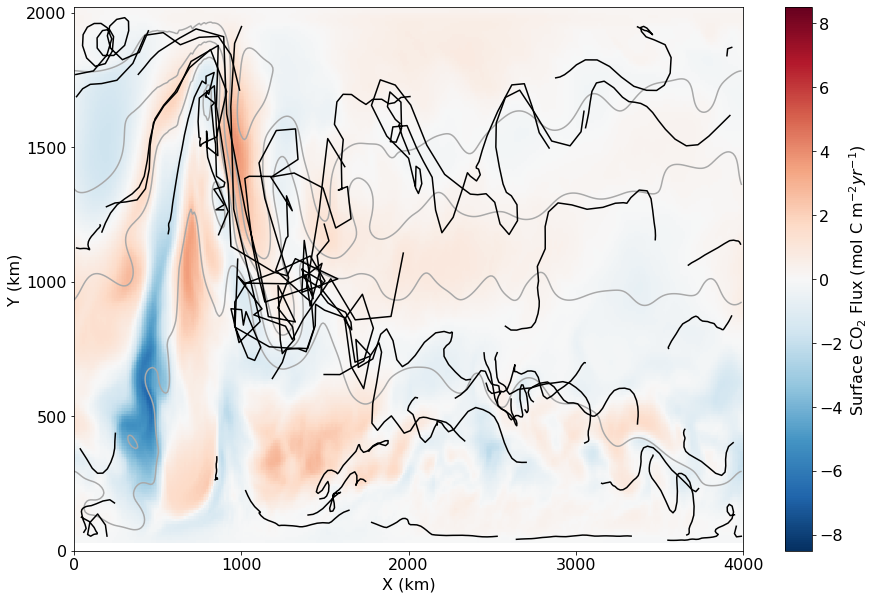

In [36]:
lons = dst.lon[indices,1:-1].where(abs(dst.lon[indices,1:-1]-dst.lon[indices,2:])<1e6)
lats = dst.lat[indices,1:-1].where(abs(dst.lon[indices,1:-1]-dst.lon[indices,2:])<1e6)

fig, ax = plt.subplots()
(-3600*24*360*zflux).plot(vmin = -8.5, vmax = 8.5, cmap=plt.cm.RdBu_r,cbar_kwargs={'label': 'Surface CO$_2$ Flux (mol C m$^{-2} yr^{-1}$)'})
((ds.UVEL[:,:-3].mean(dim='time')*ds.dyG*ds.drF[:-3]/1e6).sum(dim='Z').cumsum(dim='YC')).plot.contour(levels = 11, colors='darkgray',linewidth=1,linestyles='solid')
plt.plot(lons.T,lats.T,'k')
plt.title('')
plt.yticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.ylabel('Y (km)')
plt.xticks([0,1000000,2000000,3000000,4000000],[0,1000,2000,3000,4000])
plt.xlabel('X (km)')

plt.savefig(plot_dir+'ArgoCO2Flux'+'dop15'+'.eps',bbox_inches='tight')
#plt.colorbar()


fig, ax = plt.subplots()
(-3600*24*360*ds4.DICFLX[:,3:-2].mean(dim='time')).plot(vmin = -8.5, vmax = 8.5, cmap=plt.cm.RdBu_r,cbar_kwargs={'label': 'Surface CO$_2$ Flux (mol C m$^{-2} yr^{-1}$)'})
((ds.UVEL[:,:-3].mean(dim='time')*ds.dyG*ds.drF[:-3]/1e6).sum(dim='Z').cumsum(dim='YC')).plot.contour(levels = 11,colors = 'darkgray',linewidth=1,linestyles='solid')
plt.title('')
plt.yticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.ylabel('Y (km)')
plt.xticks([0,1000000,2000000,3000000,4000000],[0,1000,2000,3000,4000])
plt.xlabel('X (km)')

plt.savefig(plot_dir+'CO2Flux'+'dop15'+'.eps',bbox_inches='tight')

plt.figure()
(3600*24*360*(ds4.DICFLX[:,3:202].mean(dim='time')-zflux)).plot(vmin = -8.5, vmax = 8.5, cmap=plt.cm.RdBu_r,cbar_kwargs={'label': 'Surface CO$_2$ Flux (mol C m$^{-2} yr^{-1}$)'})
((ds.UVEL[:,:-3].mean(dim='time')*ds.dyG*ds.drF[:-3]/1e6).sum(dim='Z').cumsum(dim='YC')).plot.contour(levels = 11,colors = 'darkgray',linewidth=1,linestyles='solid')
plt.plot(lons.T,lats.T,'k')
plt.title('')
plt.yticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.ylabel('Y (km)')
plt.xticks([0,1000000,2000000,3000000,4000000],[0,1000,2000,3000,4000])
plt.xlabel('X (km)')

plt.savefig(plot_dir+'DiffCO2Flux'+'dop15'+'.eps',bbox_inches='tight')

## Calculate air-sea CO2 fluxes after mapping

In [22]:
print(indices)

[222 211 436 154 448 137 304 315  33 540  56 196 345 305  42 683  97  25
 264 128 573 770 630 481 227  79 759 708 445 111 500 441 220]


## Calculate error

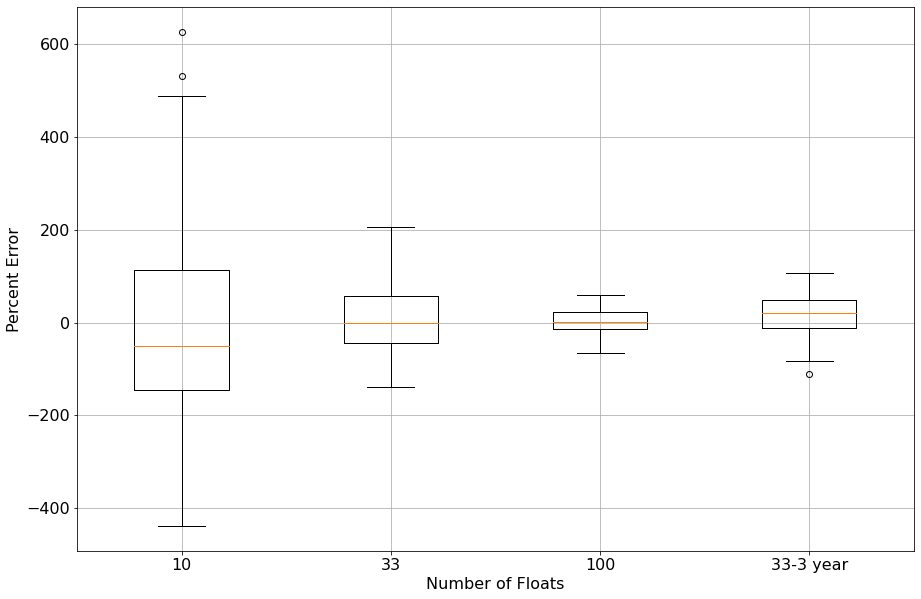

In [15]:
percentdif3yr = [-0.48348319, -0.37603428,  0.10797343,  0.19447144, -0.81908457,  0.49064133,
 -0.53698793, -0.45998205,  0.2773921,   0.08060383, -0.24057632, -0.56088215,
  0.2254254 , -0.19886335, -0.2459952 ,  0.61302686,  0.17551692, -0.2462155,
  1.10929105,  0.21829693, -0.51935145, -0.62582258, -0.65989625, -0.57167841,
  0.08035246, -1.06216895,  0.04704961, -0.56779617, -0.34755412, -0.34148621, -0.06874934,
 -0.34438323,  0.82751851,  0.30852857,  0.10343731, -0.4406122 , -0.68539979,
 -0.69151491,  0.16727668, -0.23444439, -0.28058617,  0.20395227,  0.02684135,
  0.2340306 ,  0.23278645, -0.57463918, -0.88116984,  0.25198512, -0.69167195,
  0.13590598, -0.65393928, -0.29565277,  0.15220283, -0.06596794, -0.24475502, -0.12979916,
  0.01774034,  0.08848254, -0.12932802, -0.31049011, -0.18967509,  0.68367518,
 -0.45282029, -0.48379283,  0.06582595, -0.08201648, -0.63436423, -0.32304761,
  0.02299763, -0.28445761, -1.04620387,  0.20429104, -0.26520793, -1.03063832,
 -0.26898388,  0.46204168, -0.60391069 -0.41544951 , -0.03484439, -0.1509235,  -1.00674089,
 -0.00347144,  0.21515264, -0.37282837,  0.59050098 , 0.0294632 , -0.92207276,
 -0.44018612, -0.5969393 , -0.23142077 -0.28915487, -0.12939805,  0.49673081,
  0.08353983, -0.07715222,  0.30836305 -0.25748807,  0.11231366, -0.37168019,
 -0.94385807]


percentdif10 = [ 4.38439211,  3.15359798,  1.33030434, -2.0933845,   0.64514962, -3.09015241,
 -4.88181545,  2.88259268,  0.73318093,  1.46461004, -3.12960859, -4.12286812,
 -0.50381425,  0.99678825,  4.00729503, -0.72729209,  3.63747977, -2.8745737,
 -0.53008882,  2.49593905,  3.44113814,  1.40997199,  1.60663623, -2.70782266,
 -0.5088362 , -1.97156522,  0.19476766,  0.062047  , -1.09849943, -2.80009239,
  0.14489884, -2.11504978,  0.5488039 ,  1.21344728, -0.68638573, -5.3136385,
  0.81977955,  0.0427188,  -1.40987393,  0.65890179,  0.41010282,  2.23437812,
  1.60299343,  1.12223354, -2.30826897, -2.76301092, -2.01023504,  1.84501806,
  2.24994117, -1.03346096,  0.60242595, -2.04118403, -1.95231828,  1.37136291,
  2.36402496,  0.81123498,  1.4340644 ,  1.68799586,  2.46942875, -1.62057706,
  1.47682307, -0.26578981, -3.33854681,  1.91750593,  1.12278209,  1.19179937,
  0.1560073,  -0.97919048,  0.67572827,  0.87177912,  1.29911122,  0.77601458,
  1.67307126,  1.51425977, -0.67487515,  0.16057472, -0.12390842, -0.99249919,
 -1.22095136,  2.02194779, -3.78602142,  3.21525902,  3.85300267, -6.2604376,
  0.46119583,  0.18640036,  0.33817471,  0.55271241, -0.88918842, -1.69040513,
  1.45811348, -3.27299671,  3.85414648,  1.09309474, -2.42540912,  1.17799572,
  0.22307465,  0.66900271,  0.23699374,  2.65073329]

percentdif33 = [0.01528214,  1.35645487, -0.19625053, -2.06563712,  0.24944468, -0.50775219,
  1.09334128, -1.05488083,  0.22664607, -0.1229569,  -0.22189298,  0.54426378,
  0.50947934, -0.18110073, -1.42529103, -1.00169847,  0.02308705, -1.33684822,
 -0.6566751 , -0.56543885, -0.8094119 , -0.00274814,  0.87444567,  0.38793882,
 -0.01339433, 1.39539806 ,-0.03726072 , 0.16476715 , 0.11018323 , 1.14219494,  0.03057304,
  0.48450069,  1.25518207,  1.14841034,  0.7059224 , -0.70934106,  0.29547841,
  0.90073582,  0.3463668 , -0.29437508, -0.28567712,  1.0267278 , -0.46992252,
 -0.48821988, -0.95943143, -0.64151081,  0.4791916 ,  0.25388933, -0.22534759,
  0.26311898, 0.96673037 , 0.43074852 , 0.78045024 ,-1.31763859 , 1.35046035, -0.16995632,
  1.11596858, -1.08200219,  0.81431698,  0.43028718, -2.01586655,  1.19477572,
  0.81288776, -0.67975136, -0.04663933, -0.21076953,  0.65755657, -1.14874996,
 -1.52096279, -0.09073607,  0.39942674,  0.1379704 ,  0.25945103,  0.22431108,
 -1.07847578, -0.4246931 ,  0.36307386,  0.43411072,  1.39293435, -0.58146035, -0.60932343,
  0.4112344 , -0.19433892,  1.27902648,  0.09809912,  0.26912231,  0.03700632,
  1.17619578, -0.73217606, -0.46087274, -0.34434693, -1.13934386, -0.8085433,
 -0.27227584, -0.71518085,  0.17601954, -0.02588255, -0.40098641, -1.03129883,
 -1.16677885]


percentdif32 = [ -0.24026012,  0.48909635, -1.3748029,   0.50755827,  0.38287512, -0.47146149,
 -0.04703902, -0.60267057,  0.45202206, -2.55399038, -0.69767325,  0.40727696,
  0.07012326, -0.54335637,  1.00854797, -0.80440594, -0.16686392, -0.22609964,
 -0.47455253, -0.46310972,  1.62737302,  0.51355753, -1.12695509,  0.21804336,
  0.53121041,  0.09863038,  0.41795091,  0.82464887,  1.03496513, -0.65357871,
  1.34561283,  0.08519215, -0.36984887, -1.19613945, -1.15295293, -0.3787626,
  0.03966103, -0.57323139, -0.17154016,  0.41524429,  0.07464439, -0.5446969,
  1.40385282,  0.09222559, -0.16832468,  0.88508237,  0.88066331, -0.41667686,
  0.63456146,  0.29330749, -0.8882733 , -0.76503399,  0.42168122, -0.14103402,
  0.79352519, -0.39200328, -0.23229666,  0.25177314,  0.14311142, -0.68205275,
 -0.31212313,  0.29151559,  0.00633537, -0.31918022, -0.41934293,  0.07723495,
 -0.09923581, -0.00337695, -0.29721912,  0.15546148,  0.85352535,  0.5821571,
 -1.05268757,  0.6379464 , -0.36309057, -0.58733108, -0.53083907,  0.82775158,
 -1.08920216,  0.37470925,  0.11624418, -0.52077758,  0.01622019, -0.69061297,
 -0.11134259,  0.56246862,  0.31043201,  0.49621673, -0.55056383, -0.83172,
  0.02617801, -0.00921881, -0.17388282, -0.48579463,  0.01335396,  0.63040623,
  0.72814305,  1.5362411 , -0.02993537,  0.35037089];

percentdif100 = [ -0.01967765,  0.15232863,  0.45796518,  0.24995473,  0.09822574,  0.02572103,
 -0.07301506, -0.16288301,  0.07028848, -0.00164023, -0.35606719,  0.23490826,
 -0.14922584,  0.0049195 , -0.23900502, -0.23806705,  0.0126849 ,  0.02242172,
  0.6645848 , -0.16886812, -0.32628829, -0.22793673,  0.07332395,  0.14933732,
 -0.18638355,  0.2725992 ,  0.1949586 , -0.01190275,  0.14132085,  0.15079233,
 -0.11574393, -0.12545781, -0.35574973, -0.5932249 ,  0.2666204 ,  0.12391355,
  0.01192348, -0.13740431, -0.3517132 ,  0.06842387, -0.04882392, -0.51217365,
  0.60128121, -0.24434893,  0.0303771 , -0.33635935,  0.12840173,  0.61165461,
  0.29334768,  0.34827639, -0.07934567, -0.36150448,  0.01465507, -0.00372702,
 -0.07232763, -0.20547065, -0.15912554,  0.1572149 ,  0.01715316, -0.26394985,
 -0.5589322 , -0.18394295, -0.19338707,  0.00855317,  0.43390427,  0.09029213,
  0.25165875,  0.37702095, -0.00710639, -0.11094842, -0.24867151, -0.35876487,
 -0.00581054, -0.26614252,  0.2415895 ,  0.11170661, -0.00648639, -0.30040193,
  0.38602038,  0.1998147 , -0.49664639, -0.05057166, -0.05768547, -0.17711454,
  0.34271874, -0.24517147, -0.22681049, -0.32083636, -0.11499068, -0.23878877,
  0.0387285 ,  0.04400641,  0.22899173, -0.06662409, -0.53927104,  0.03375261,
 -0.26287454, -0.05574417,  0.18602907, -0.29784278];

#percentdif10pos = percentdif10(np.where(percentdif10>>0))

plt.figure()
plt.boxplot((-100*np.array(percentdif10).T,-100*np.array(percentdif33).T,-100*np.array(percentdif100),-100*np.array(percentdif3yr)))
#plt.xscale('log')
plt.xlabel('Number of Floats')
plt.ylabel('Percent Error')
plt.grid()
plt.xticks([1,2,3,4],[10,33,100,'33-3 year'])
plt.savefig(plot_dir+'RandomError'+'.eps')

In [23]:
q3, q1 = np.percentile(-100*np.array(percentdif3yr).T, [75 ,25])
print(q3)
print(q1)

mean = np.mean(-100*np.array(percentdif3yr).T)
print(mean)

median = np.median(-100*np.array(percentdif3yr).T)
print(median)


48.379283
-10.797343
18.402127597938147
19.886335


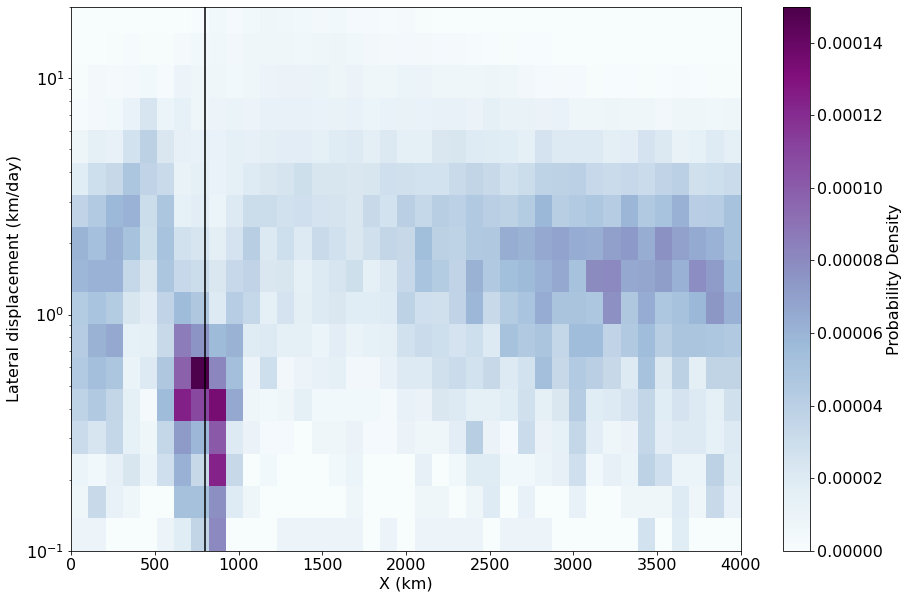

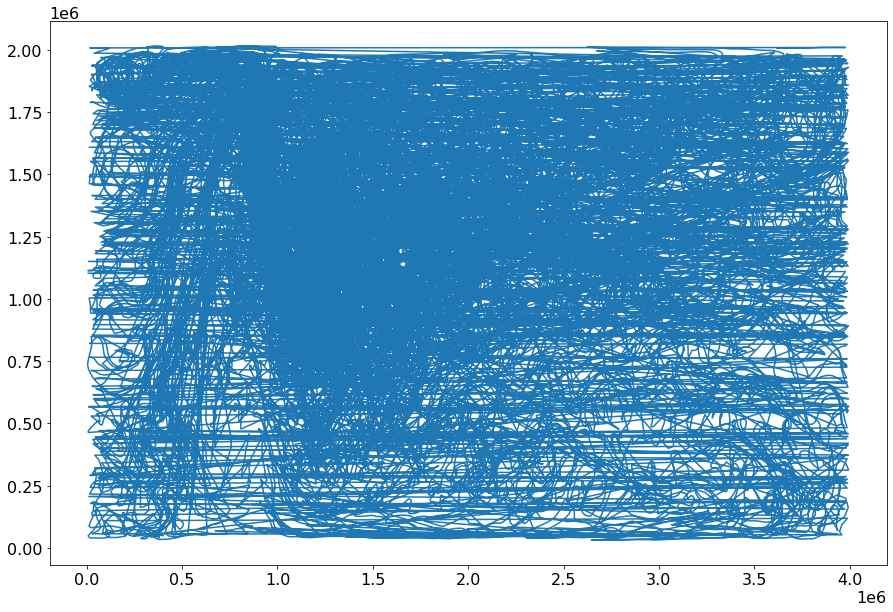

In [19]:
lonvec = np.array(dst.lon[:,1:]).flatten()
lonvec  = lonvec[~np.isnan(lonvec)]

latvec = np.array(dst.lat[:,1:]).flatten()
latvec  = latvec[~np.isnan(latvec)]

horzvec = np.array(np.sqrt((dst.lat[:,1:]-dst.lat[:,:-1])**2 + (dst.lon[:,1:]-dst.lon[:,:-1])**2)) 
horzvec = horzvec[~np.isnan(horzvec)]

newhorz = horzvec[horzvec<3500000]
newlon = lonvec[horzvec<3500000]
newlat = latvec[horzvec<3500000]

logbins = np.logspace(-1,np.log10(40),20)
lonbins = np.linspace(0,4000,40)
plt.figure()
plt.hist2d(newlon/1000,newhorz/10000,[lonbins,logbins],density=True,cmap='BuPu')
plt.plot(800*(logbins*0+1),logbins,'k')
plt.colorbar(label = 'Probability Density')
plt.yscale('log')
plt.ylabel('Lateral displacement (km/day)')
plt.xlabel('X (km)')
plt.ylim(1e-1,2e1)
plt.savefig(plot_dir+'LateralDisplacement'+'dop15'+'.eps',bbox_inches='tight')

plt.figure()
plt.plot(newlon,newlat)



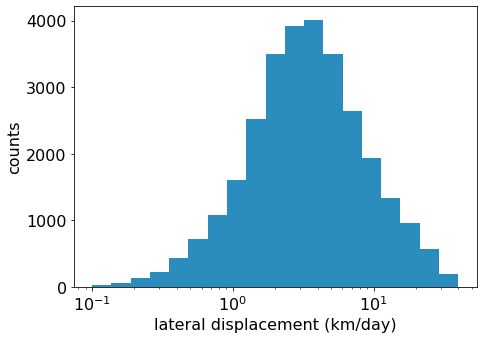

In [20]:
fig,ax = plt.subplots(1,1,figsize = (7,5))
ax.hist(newhorz/10000,bins = logbins,color = '#2b8cbe')
ax.set_xscale('log')
ax.set_xlabel('lateral displacement (km/day)')
ax.set_ylabel('counts')
fig.tight_layout()
plt.savefig(plot_dir+'Hist'+'dop15'+'.eps',bbox_inches='tight')

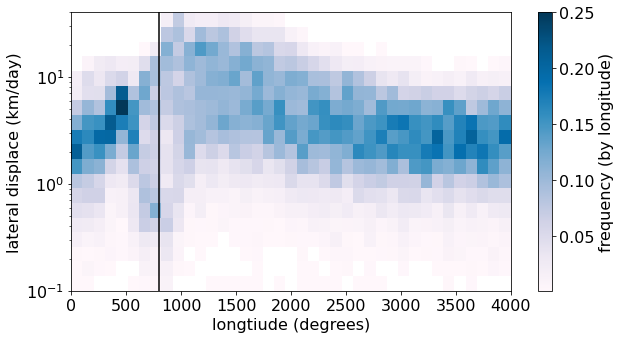

In [24]:
fig,ax = plt.subplots(1,1,figsize = (9,5))
hist, xedges, yedges = np.histogram2d(newlon/1000,newhorz/10000,bins = [lonbins,logbins])
hist = hist.T
with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
    hist = hist / hist.sum(axis=0, keepdims=True)
hist[hist == 0] = np.nan
h = ax.pcolormesh(xedges, yedges, hist, cmap='PuBu')
ax.plot(800*(logbins*0+1),logbins,'k')
ax.set_yscale('log')
ax.set_ylabel('lateral displace (km/day)')
ax.set_xlabel('longtiude (degrees)')
plt.colorbar(h,label = 'frequency (by longitude)')
fig.tight_layout()
plt.savefig(plot_dir+'LateralDisplacement'+'dop15'+'.eps',bbox_inches='tight')
#fig.savefig('all_floats.png')

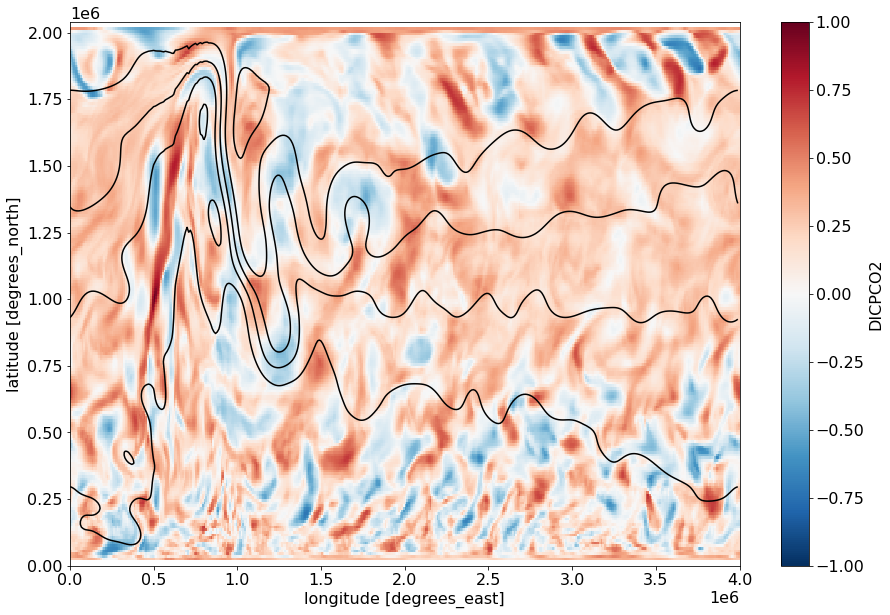

In [23]:
correlation = xr.corr(ds.DICPCO2[:,100,50],ds.DICPCO2,'time')

plt.figure()
correlation.plot()
((ds.UVEL[:,:-3].mean(dim='time')*ds.dyG*ds.drF[:-3]/1e6).sum(dim='Z').cumsum(dim='YC')).plot.contour(levels = 11,colors = 'black',linewidth=1,linestyles='solid')